# Notes

Fourth iteration of the modeling:
- modulirized data processing
- model serialization

In [21]:
import os 
import re
import csv
import json
import math
import random

from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# Constants

In [22]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [23]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'patients_augmented')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

**TODO** Implement augmenation and patients sessions for the new data set

# Data prep

### Build training set

In [24]:
from utils.input import setup, exercise_to_input

In [25]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'LefteyeMidbottom': 'orbital',
  'LefteyeMidtop': 'orbital',
  'LefteyeInnercorner': 'orbital',
  'LefteyeOutercorner': 'orbital',
  'LefteyebrowInner': 'frontal',
  'LefteyebrowCenter': 'frontal',
  'RighteyeMidbottom': 'orbital',
  'RighteyeMidtop': 'orbital',
  'RighteyeInnercorner': 'orbital',
  'RighteyeOutercorner': 'orbital',
  'RighteyebrowInner': 'frontal',
  'RighteyebrowCenter': 'frontal',
  'NoseTip': 'frontal',
  'MouthLowerlipMidbottom': 'oral',
  'MouthLeftcorner': 'oral',
  'MouthRightcorner': 'oral',
  'MouthUpperlipMidtop': 'oral',
  'ChinCenter': 'oral',
  'ForeheadCenter': 'frontal',
  'LeftcheekCenter': 'oral',
  'RightcheekCenter': 'oral'},
 'BASES': {'LefteyeMidbottom': 'ForeheadCenter',
  'LefteyeMidtop': 'ForeheadCenter',
  'LefteyeInnercorner': 'ForeheadCenter',
  'LefteyeOutercorner': 'ForeheadCenter',
  'LefteyebrowInner': 'ForeheadCenter',
  'LefteyebrowCenter': 'ForeheadCenter

In [26]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
    #dir_exercises_augmented
]

In [27]:
feature_engineering_setting = {
    'coordinates': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': False,
    'distance': False,
    're_base': True,
    'transformation_to_rebase': False,
    'extended_meta': True,
}

In [28]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()

for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue
            
        data = json.load(open(file_path, 'r'))

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)

        yslist.append(_ys)
        xslist_meta.append(_xs_meta)  
        xslist_global.append(_xs_global)
        xslist_frontal.append(_xs_frontal)
        xslist_oral.append(_xs_oral)
        xslist_orbital.append(_xs_orbital)
            
ys = np.array(yslist, dtype='int')
xs_meta = np.array(xslist_meta, dtype='float32')   
xs_global = np.array(xslist_global, dtype='float32') 
xs_frontal = np.array(xslist_frontal, dtype='float32') 
xs_oral = np.array(xslist_oral, dtype='float32') 
xs_orbital = np.array(xslist_orbital, dtype='float32') 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(2419,)
(2419, 52)
(2419, 126, 600)
(2419, 36, 600)
(2419, 42, 600)
(2419, 48, 600)


In [29]:
print(ys)

[2 0 3 ... 2 1 5]


## Modeling

In [30]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [31]:
def get_dnn(inputLayer): 
    m = Dense(4, activation="relu")(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [32]:
def get_cnn(inputLayer):
    chanDim = -1
    
    m = Conv1D(8, (32), padding='same', activation='relu')(inputLayer)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Conv1D(16, (64), padding='same', activation='relu')(m)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Conv1D(32, (64), padding='same', activation='relu')(m)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Conv1D(64, (128), padding='same', activation='relu')(m)
    m = BatchNormalization(axis=chanDim)(m)
    m = MaxPooling1D((2))(m)
    m = Flatten()(m)
    m = Dropout(0.5)(m)
    m = Dense(128, activation="relu")(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [33]:
def get_model():
    input_meta = Input(shape=xs_meta.shape[1:])
    model_meta = get_dnn(input_meta)
    
    input_global = Input(shape=xs_global.shape[1:])
    model_global = get_cnn(input_global)
    
    input_frontal = Input(shape=xs_frontal.shape[1:])
    model_frontal = get_cnn(input_frontal)  

    input_oral = Input(shape=xs_oral.shape[1:])
    model_oral = get_cnn(input_oral)  
    
    input_orbital = Input(shape=xs_orbital.shape[1:])
    model_orbital = get_cnn(input_orbital)  
    
    
    model_contatenate = concatenate([
        model_meta.output, 
        model_global.output,
        model_frontal.output,
        model_oral.output,
        model_orbital.output,
    ])
    
    model_contatenate = Dense(32, activation="relu")(model_contatenate)
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_meta.input,
        model_global.input,
        model_frontal.input,
        model_oral.input,
        model_orbital.input
    ], outputs=model_contatenate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    
    return model

In [34]:
test_model = get_model()
test_model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 126, 600)]   0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 36, 600)]    0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 42, 600)]    0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 48, 600)]    0           []                               
                                                                                           

 batch_normalization_34 (BatchN  (None, 31, 32)      128         ['conv1d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_38 (BatchN  (None, 9, 32)       128         ['conv1d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_42 (BatchN  (None, 10, 32)      128         ['conv1d_43[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_46 (BatchN  (None, 12, 32)      128         ['conv1d_47[0][0]']              
 ormalizat

                                                                                                  
 concatenate_2 (Concatenate)    (None, 516)          0           ['dense_15[0][0]',               
                                                                  'dense_16[0][0]',               
                                                                  'dense_17[0][0]',               
                                                                  'dense_18[0][0]',               
                                                                  'dense_19[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 32)           16544       ['concatenate_2[0][0]']          
                                                                                                  
 dense_21 (Dense)               (None, 6)            198         ['dense_20[0][0]']               
          

In [35]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


### K-fold evaluation

In [36]:
k = 5
k_limit = 5
train = 0.8
val = 0.2
test = 0.2

In [37]:
VERBOSE = 0
EPOCHS = 400
BATCH_SIZE = 8

In [38]:
from sklearn.model_selection import KFold

In [39]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [40]:
%matplotlib inline

{0: 0.3805309734513274, 1: 1.1889400921658986, 2: 1.015748031496063, 3: 2.4339622641509435, 4: 2.7157894736842105, 5: 1.303030303030303}


2024-02-19 21:14:16.790752: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-19 21:14:19.142919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-19 21:14:49.172003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-19 22:53:32.045950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.69      0.39      0.50       234
           1       0.32      0.36      0.34        67
           2       0.35      0.49      0.41        61
           3       0.38      0.42      0.40        26
           4       0.43      0.71      0.53        28
           5       0.37      0.62      0.46        68

    accuracy                           0.45       484
   macro avg       0.42      0.50      0.44       484
weighted avg       0.52      0.45      0.46       484

{0: 0.3669985775248933, 1: 1.1889400921658986, 2: 1.1120689655172413, 3: 2.606060606060606, 4: 2.8351648351648353, 5: 1.2524271844660195}


2024-02-19 22:53:43.698351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-19 22:54:09.899012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 00:28:43.100096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       209
           1       0.14      1.00      0.24        67
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        32
           5       0.00      0.00      0.00        60

    accuracy                           0.14       484
   macro avg       0.02      0.17      0.04       484
weighted avg       0.02      0.14      0.03       484

{0: 0.37445573294629897, 1: 1.2, 2: 1.0530612244897959, 3: 2.58, 4: 2.74468085106383, 5: 1.2585365853658537}


2024-02-20 00:28:54.323366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 00:29:26.062183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 02:03:49.300394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       223
           1       0.00      0.00      0.00        69
           2       0.00      0.00      0.00        70
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        29
           5       0.13      1.00      0.22        61

    accuracy                           0.13       484
   macro avg       0.02      0.17      0.04       484
weighted avg       0.02      0.13      0.03       484

{0: 0.36338028169014086, 1: 1.1889400921658986, 2: 1.131578947368421, 3: 2.5544554455445545, 4: 2.8351648351648353, 5: 1.2835820895522387}


2024-02-20 02:04:05.701433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 02:04:46.353362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 03:39:15.618663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       202
           1       0.00      0.00      0.00        67
           2       0.00      0.00      0.00        87
           3       0.00      0.00      0.00        31
           4       0.00      0.00      0.00        32
           5       0.13      1.00      0.24        65

    accuracy                           0.13       484
   macro avg       0.02      0.17      0.04       484
weighted avg       0.02      0.13      0.03       484

{0: 0.3669985775248933, 1: 1.2169811320754718, 2: 1.1025641025641026, 3: 2.58, 4: 2.6597938144329896, 5: 1.2772277227722773}


2024-02-20 03:39:34.656546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 03:40:15.283429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-20 05:15:15.166815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.78      0.82      0.80       230
           1       0.68      0.41      0.51        74
           2       0.60      0.58      0.59        64
           3       0.76      0.71      0.73        31
           4       0.78      0.78      0.78        23
           5       0.56      0.77      0.65        61

    accuracy                           0.71       483
   macro avg       0.69      0.68      0.68       483
weighted avg       0.71      0.71      0.70       483



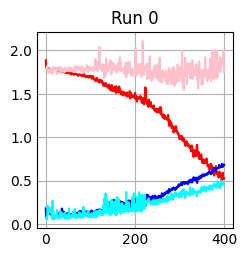

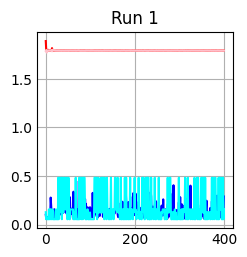

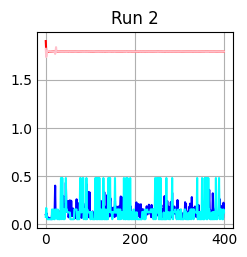

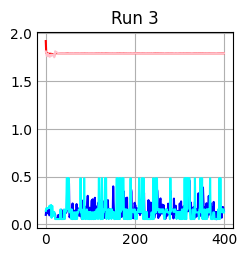

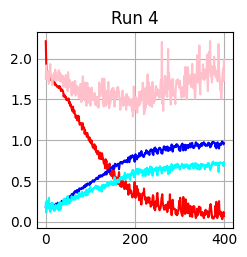

In [41]:
indxs = get_k_indx(k, len(ys))
models = []

for i in range(k_limit):
    train_indx, val_indx, test_indx  = indxs[i]
    xs_meta_i = xs_meta[train_indx]
    xs_meta_i_val = xs_meta[val_indx]
    xs_meta_i_test = xs_meta[test_indx]
    
    xs_global_i = xs_global[train_indx]
    xs_global_i_val = xs_global[val_indx]
    xs_global_i_test = xs_global[test_indx]
    
    xs_frontal_i = xs_frontal[train_indx]
    xs_frontal_i_val = xs_frontal[val_indx]
    xs_frontal_i_test = xs_frontal[test_indx]
    
    xs_oral_i = xs_oral[train_indx]
    xs_oral_i_val = xs_oral[val_indx]
    xs_oral_i_test = xs_oral[test_indx]
    
    xs_orbital_i = xs_orbital[train_indx]
    xs_orbital_i_val = xs_orbital[val_indx]
    xs_orbital_i_test = xs_orbital[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]
    
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(ys_i),
                                                 y=ys_i)
    available_classes = np.unique(ys_i)
    weight_training_classes = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
    }
    
    for indx, value in enumerate(class_weights):
        weight_training_classes[available_classes[indx]] = value

    print(weight_training_classes)

    model = get_model()

    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20)
    ]
    
    hist = model.fit(
        x=[
            xs_meta_i, 
            xs_global_i, 
            xs_frontal_i,
            xs_oral_i,
            xs_orbital_i], y=ys_i, 
        validation_data=([
            xs_meta_i_val,
            xs_global_i_val,
            xs_frontal_i_val,
            xs_oral_i_val,
            xs_orbital_i_val], ys_i_val),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #callbacks=model_callbacks,
        verbose=VERBOSE)
    
    models.append(model)
    
    # visualizing losses and accuracy
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['accuracy']
    val_acc    = hist.history['val_accuracy']
    xc         = range(len(hist.history['loss']))    
    
    plt.figure()
    plt.title(f'Run {i}')
    plt.plot(xc, train_loss, color='red')
    plt.plot(xc, val_loss, color='pink')
    plt.plot(xc, train_acc, color='blue')
    plt.plot(xc, val_acc, color='cyan')
    
    y_pred = model.predict([
        xs_meta_i_test,
        xs_global_i_test,
        xs_frontal_i_test,
        xs_oral_i_test,
        xs_orbital_i_test],verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(ys_i_test, y_pred_bool))

# Model Serialization 

In [42]:
serialize = False
best_model = 2

In [ ]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe_no-aug_005')

In [ ]:
if serialize:
    model = models[best_model]
    model.save(dir_model)